**Example of Coordinate Based HP-Lattice model**

by: Hanna Linn

In [17]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (1, 1, 1)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-1, -1, -1, -1, -1, -1, -1, -1]
T:
[[ 0.  2.  0.  0.  1.  0. -1. -1.]
 [ 2.  0.  0.  0.  0.  1. -1. -1.]
 [ 0.  0.  0.  2.  0.  0.  1.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  1.  0.  0.  2.  0.  0.  0.]
 [-1. -1.  1.  0.  0.  0.  0.  2.]
 [-1. -1.  0.  1.  0.  0.  2.  0.]]
Dn:
[2, 2, 2, 2]


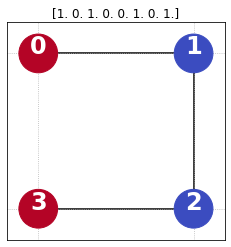

In [3]:
# Draw the protein
protein.viz_lattice(feasible_set[0])

[1. 0. 1. 0. 0. 1. 0. 1.]
[1. 0. 0. 1. 0. 1. 1. 0.]
[0. 1. 1. 0. 1. 0. 0. 1.]
[0. 1. 0. 1. 1. 0. 1. 0.]


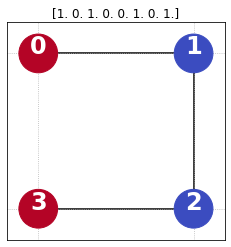

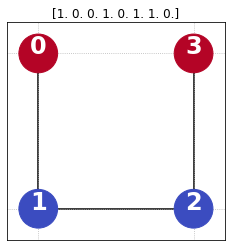

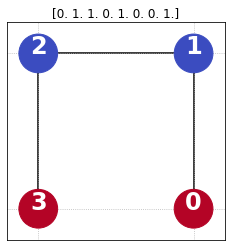

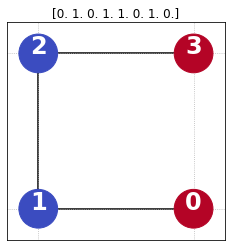

In [4]:
# Draw all proteins in feasible solution set
for j,i in enumerate(feasible_set):
    plt.figure(j)
    protein.viz_lattice(i)
    print(i)

In [5]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

print('H_cost:\n' + str(H_cost))
print()
print('H_mixer:\n' + str(H_mixer))

H_cost:
  (-0.25) [Z4]
+ (-0.25) [Z5]
+ (-0.25) [Z2]
+ (-0.25) [Z3]
+ (0.25) [Z6]
+ (0.25) [Z7]
+ (0.25) [Z0]
+ (0.25) [Z1]
+ (-0.25) [Z0 Z6]
+ (-0.25) [Z0 Z7]
+ (-0.25) [Z1 Z6]
+ (-0.25) [Z1 Z7]
+ (0.0) [Z0 Z2]
+ (0.0) [Z0 Z3]
+ (0.0) [Z0 Z5]
+ (0.0) [Z1 Z2]
+ (0.0) [Z1 Z3]
+ (0.0) [Z1 Z4]
+ (0.0) [Z2 Z4]
+ (0.0) [Z2 Z5]
+ (0.0) [Z2 Z7]
+ (0.0) [Z3 Z4]
+ (0.0) [Z3 Z5]
+ (0.0) [Z3 Z6]
+ (0.0) [Z4 Z6]
+ (0.0) [Z4 Z7]
+ (0.0) [Z5 Z6]
+ (0.0) [Z5 Z7]
+ (0.25) [Z0 Z4]
+ (0.25) [Z1 Z5]
+ (0.25) [Z2 Z6]
+ (0.25) [Z3 Z7]
+ (0.5) [Z0 Z1]
+ (0.5) [Z2 Z3]
+ (0.5) [Z4 Z5]
+ (0.5) [Z6 Z7]

H_mixer:
  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]
+ (1) [X7]


In [24]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params):     # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    

# If we add a expectation value we get a cost function for average cost of the cost Hamiltonian for given parameters
@qml.qnode(dev)
def average_cost(params):
    circuit(params)
    return qml.expval(H_cost)


# Let's test it!
zero_parameters = np.array([[0],[0]])
half_parameters = np.array([[0.5],[0.5]])
p = 1

print('Average cost with gamma=0 and beta=0:\n', average_cost(zero_parameters))
print('Average cost with gamma=0.5 and beta=0.5:\n', average_cost(half_parameters))

# Draw our circuit
print()
print(qml.draw(average_cost, expansion_strategy = 'device')(zero_parameters))

Average cost with gamma=0 and beta=0:
 3.469446951953614e-18
Average cost with gamma=0.5 and beta=0.5:
 1.7146454341048567

0: ──H─╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(-0.00)─╭RZZ(-0.00)──RZ(0.00)─
1: ──H─╰RZZ(0.00)─│──────────│──────────│──────────│──────────│───────────│───────────╭RZZ(0.00)
2: ──H────────────╰RZZ(0.00)─│──────────│──────────│──────────│───────────│───────────╰RZZ(0.00)
3: ──H───────────────────────╰RZZ(0.00)─│──────────│──────────│───────────│─────────────────────
4: ──H──RZ(-0.00)───────────────────────╰RZZ(0.00)─│──────────│───────────│─────────────────────
5: ──H──RZ(-0.00)──────────────────────────────────╰RZZ(0.00)─│───────────│─────────────────────
6: ──H──RZ(0.00)──────────────────────────────────────────────╰RZZ(-0.00)─│─────────────────────
7: ──H──RZ(0.00)──────────────────────────────────────────────────────────╰RZZ(-0.00)───────────

───RX(0.00)────────────────────────────────────────────────────────────────────────────────
──╭RZZ(

In [7]:
# Optimisation of the circuit

optimiser = qml.GradientDescentOptimizer()
steps = 100
initial_params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad = True)
p = 2

cost_vector = np.zeros(steps)
cost_vector[0] = average_cost(initial_params)
params_vector = np.zeros((steps, 2, p))

params = initial_params
for i in range(steps):
    params_vector[i] = params
    params, cost_ = optimiser.step_and_cost(average_cost, params)
    cost_vector[i] = cost_

best_params_optimisation = params
print('Optimal parameters:\n', best_params_optimisation)
print('Average cost for the best parameters:\n', average_cost(best_params_optimisation))

Optimal parameters:
 [[ 0.96544821 -0.45038119]
 [ 0.5847909   0.63981986]]
Average cost for the best parameters:
 -1.7206783732291704


Text(0.5, 1.0, 'Optimisation of $\\gamma$ and $\\beta$')

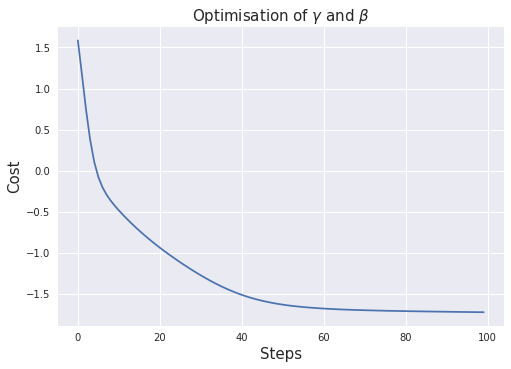

In [8]:
plt.style.use("seaborn")
plt.plot(cost_vector)
plt.xlabel('Steps', fontsize = 15)
plt.ylabel('Cost', fontsize = 15)
plt.title(r'Optimisation of $\gamma$ and $\beta$', fontsize = 15)

In [9]:
# Probability of measuring the different answers
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=qubits)

probs = probability_circuit(best_params_optimisation)


Success probability of training:  0.38593587381060557


<Figure size 576x396 with 0 Axes>

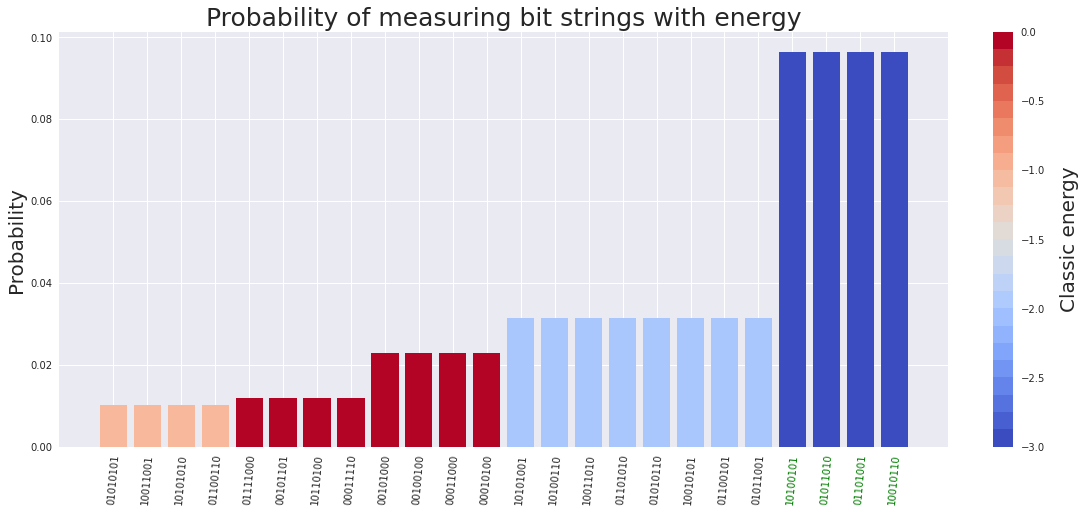

In [10]:
# Fancy plot, the one above is unclar if we succeeded
ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states

print('Success probability of training: ', np.sum(probs[ground_states_i]))
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings

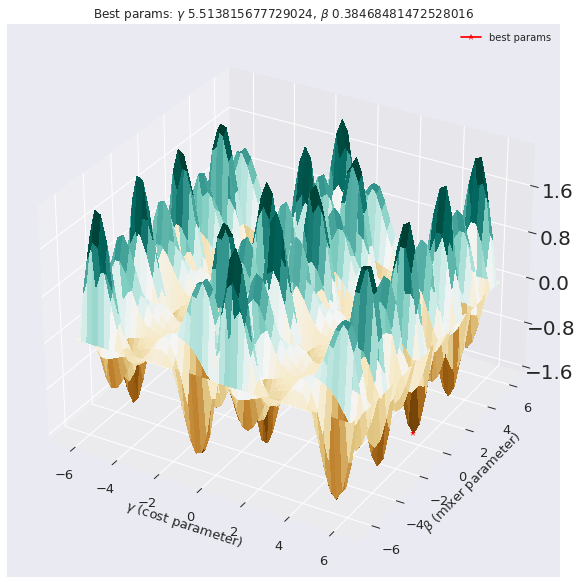

In [11]:
# Grid search
p = 1 # grid search with p > 2 is messy

start_gamma = -2*np.pi
stop_gamma = 2*np.pi
num_points_gamma = 50

start_beta = -2*np.pi
stop_beta = 2*np.pi
num_points_beta = 50

# Gamma
X = np.linspace(start_gamma, stop_gamma, num_points_gamma)
# Beta
Y = np.linspace(start_beta, stop_beta, num_points_beta)

grid_search_params, Z, i = grid_search(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta,
					average_cost,
					above = False,
					save = False)

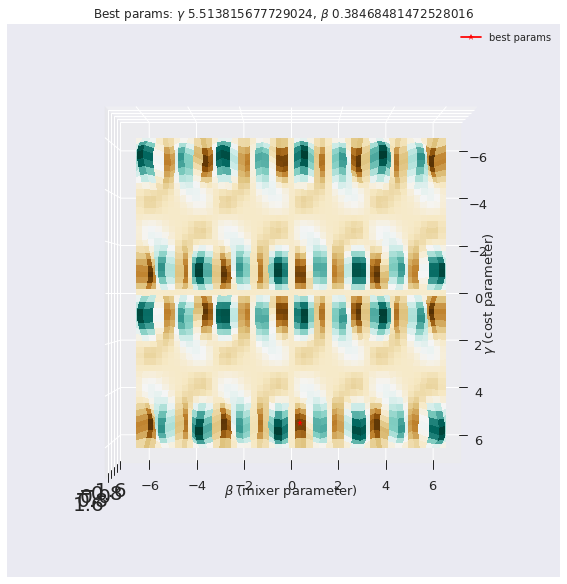

In [12]:
# More plotting, from above

X, Y, _= get_batch_array(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta)
                
plot_grid_search(X,
					Y,
					Z,
					i,
					above = True,
					name = '',
					save = False)

Success probability of grid search:  0.16189622599429074


<Figure size 576x396 with 0 Axes>

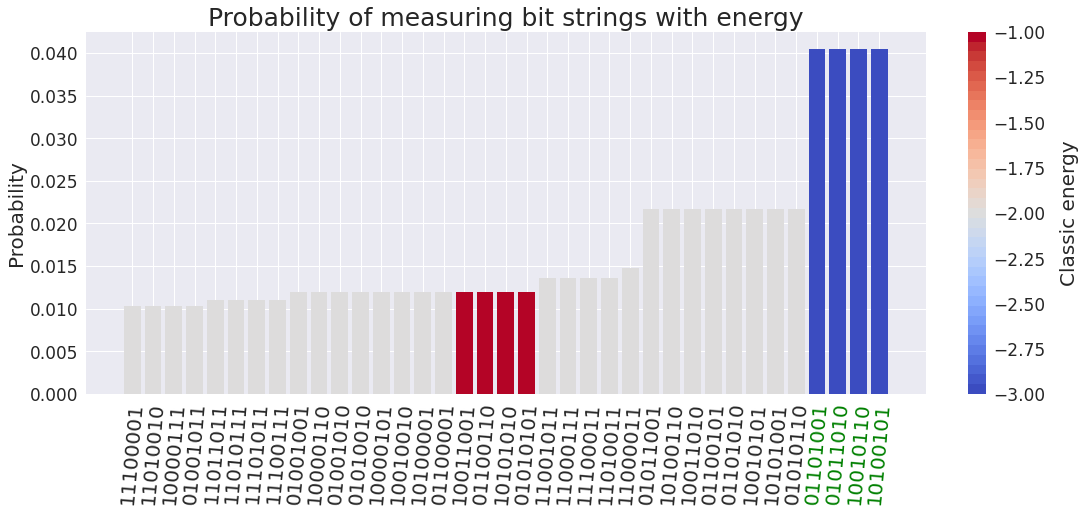

In [13]:
# Is the grid search better?
probs = probability_circuit(grid_search_params)

plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i)

print('Success probability of grid search: ', np.sum(probs[ground_states_i]))

Success probability of annealing parameters:  0.0006163687191462081


<Figure size 576x396 with 0 Axes>

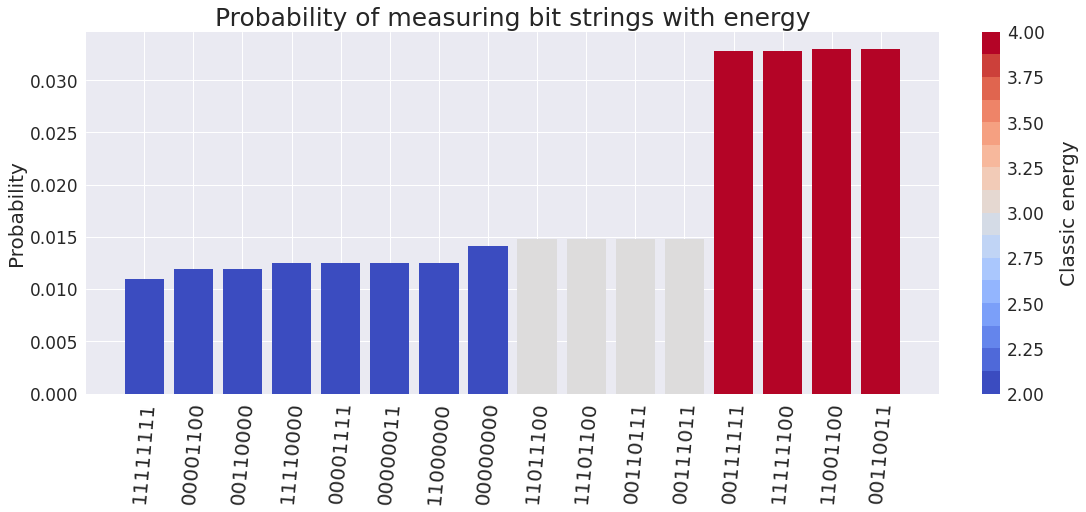

In [26]:
# Or we can do annealing parameters
annealing_params = get_annealing_params(annealing_time=2, p=15, linear = True, cosine = False)
probs = probability_circuit(annealing_params)

print('Success probability of annealing parameters: ', np.sum(probs[ground_states_i]))
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings